https://github.com/voxel51/fiftyone
https://voxel51.com/docs/fiftyone/user_guide/app.html
https://voxel51.com/docs/fiftyone/tutorials/evaluate_detections.html

In [10]:
import matplotlib.pyplot as plt
import json

In [2]:
import fiftyone as fo
from fiftyone import ViewField as F

## Paths

In [6]:
images_path = r'datasets\wgisd-master\data'
annotations_path = r'datasets\wgisd-master\coco_annotations\test_polygons_instances.json'
detections_path = r'../sample_data/test_results.json' #test_results.json

## Load dataset

In [7]:
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=images_path,
    labels_path=annotations_path,
    include_id=True,
    label_field='ground_truth',
    label_types='segmentations', #'detections' #'segmentations'
    
)

 100% |███████████████████| 27/27 [2.6s elapsed, 0s remaining, 9.9 samples/s]       


In [11]:
dataset.default_classes = [x['name'] for x in json.load(open(annotations_path))['categories']]


In [12]:
print(dataset)

Name:        2022.08.17.09.31.22
Media type:  image
Num samples: 27
Persistent:  False
Tags:        []
Sample fields:
    id:                         fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth_segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ground_truth_coco_id:       fiftyone.core.fields.IntField


In [13]:
sample1 = dataset.first()

In [14]:
d1= sample1.ground_truth_segmentations.detections[0]

In [15]:
d1.mask.shape

(621, 204)

In [16]:
d1

<Detection: {
    'id': '62fc994b33e3be5d6db2004e',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'Cabernet Franc',
    'bounding_box': BaseList([
        0.898,
        0.33624999999999994,
        0.0996,
        0.4549000000000001,
    ]),
    'mask': array([[False, False, False, ...,  True,  True,  True],
           [False, False, False, ...,  True,  True,  True],
           [False, False, False, ...,  True,  True,  True],
           ...,
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False]]),
    'confidence': None,
    'index': None,
    'supercategory': 'root',
    'iscrowd': 0,
}>

In [17]:
import matplotlib.pyplot as plt

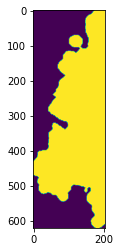

In [18]:
plt.imshow(d1.mask)


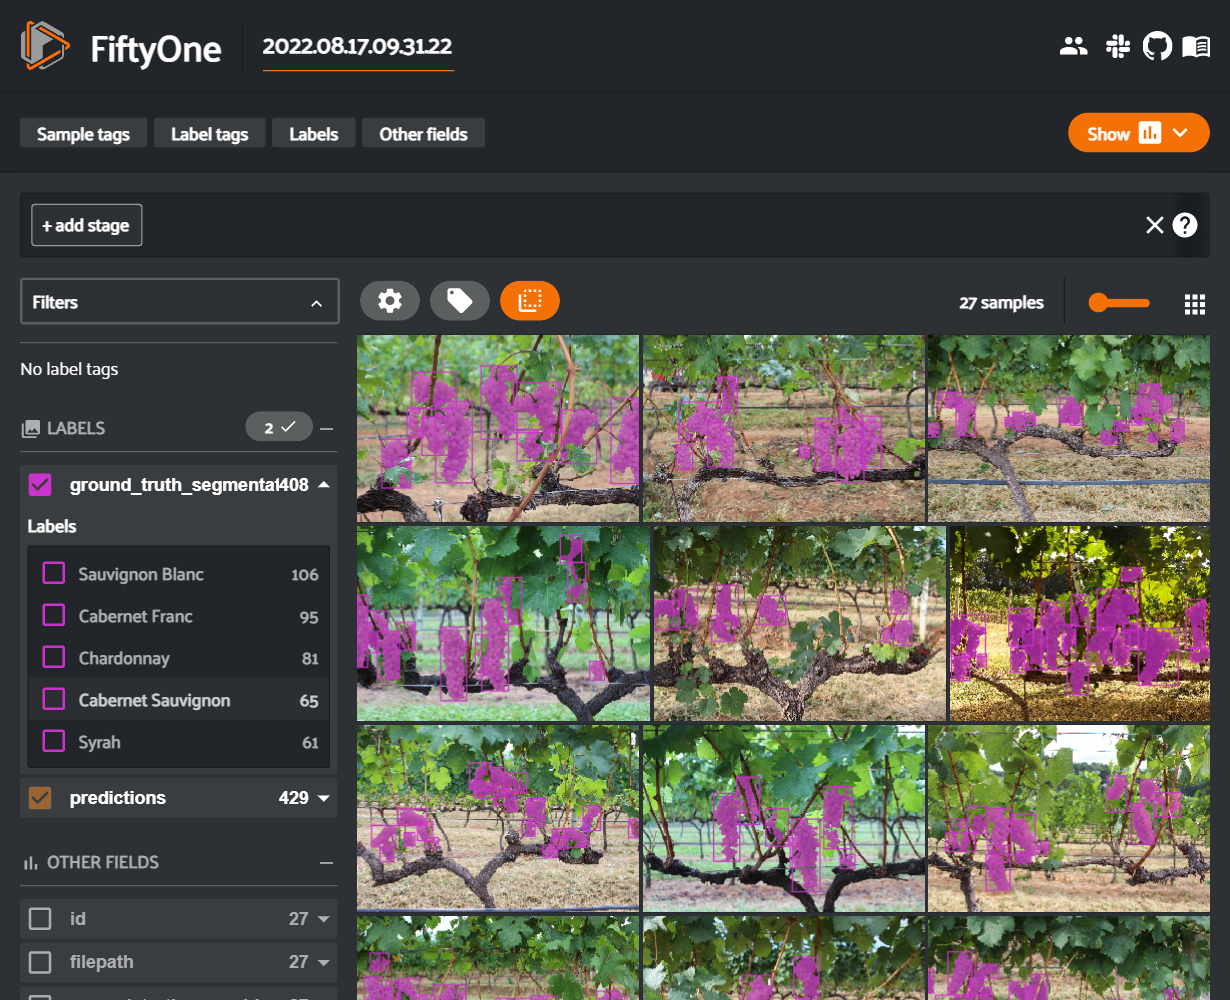

In [19]:
session = fo.launch_app(dataset)

## Load detections

In [20]:
import json
import pickle
import numpy as np

In [21]:
import pycocotools

In [22]:
predictions = json.load(open(detections_path))

In [24]:
class_names = dataset.default_classes

In [25]:
assert len(dataset) == len(predictions)
for i_sample, sample in enumerate(dataset.iter_samples()):
    preds = predictions[i_sample]
    
    w = sample.metadata.width
    h = sample.metadata.height
    
    detections = []
    for pred in preds:
        x1, y1, x2, y2 = [int(x) for x in pred['bounding_box']]
        rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
        
#         pred['mask']['counts'] = pred['mask']['counts'].encode()
        mask = pycocotools.mask.decode(pred["mask"])
        mask_box = mask[y1:y2, x1:x2]
        
        detections.append(
            fo.Detection(
                label=class_names[pred["label"]],
                bounding_box=rel_box,
                confidence=pred["confidence"],
                mask=mask_box
            )
        )
    
    sample['predictions'] = fo.Detections(detections=detections)
    sample.save()
    

In [26]:
print(dataset)

Name:        2022.08.17.09.31.22
Media type:  image
Num samples: 27
Persistent:  False
Tags:        []
Sample fields:
    id:                         fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth_segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ground_truth_coco_id:       fiftyone.core.fields.IntField
    predictions:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [27]:
half_conf_view = dataset.filter_labels("predictions", F("confidence") > 0.5)

In [28]:
session = fo.launch_app(half_conf_view) #fo.launch_app(dataset)

# Calculate results

Caution! results skip images with no detection of confidence >0.5

In [87]:
results = half_conf_view.evaluate_detections( #dataset.evaluate_detections
    "predictions",
    gt_field="ground_truth_segmentations",
    eval_key="eval",
    compute_mAP=True,
)

print("\nmAP: %.4f" % results.mAP())

Evaluating detections...
 100% |███████████████████| 27/27 [3.0s elapsed, 0s remaining, 8.4 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 27/27 [1.2s elapsed, 0s remaining, 23.4 samples/s]         

mAP: 0.1479


In [88]:
results.print_report()

                    precision    recall  f1-score   support

                 0       0.00      0.00      0.00         0
        Chardonnay       0.46      0.35      0.39        81
    Cabernet Franc       0.38      0.28      0.33        95
Cabernet Sauvignon       0.35      0.29      0.32        65
   Sauvignon Blanc       0.48      0.44      0.46       106
             Syrah       0.46      0.36      0.40        61

         micro avg       0.43      0.35      0.39       408
         macro avg       0.36      0.29      0.32       408
      weighted avg       0.43      0.35      0.39       408



Most False Positives:


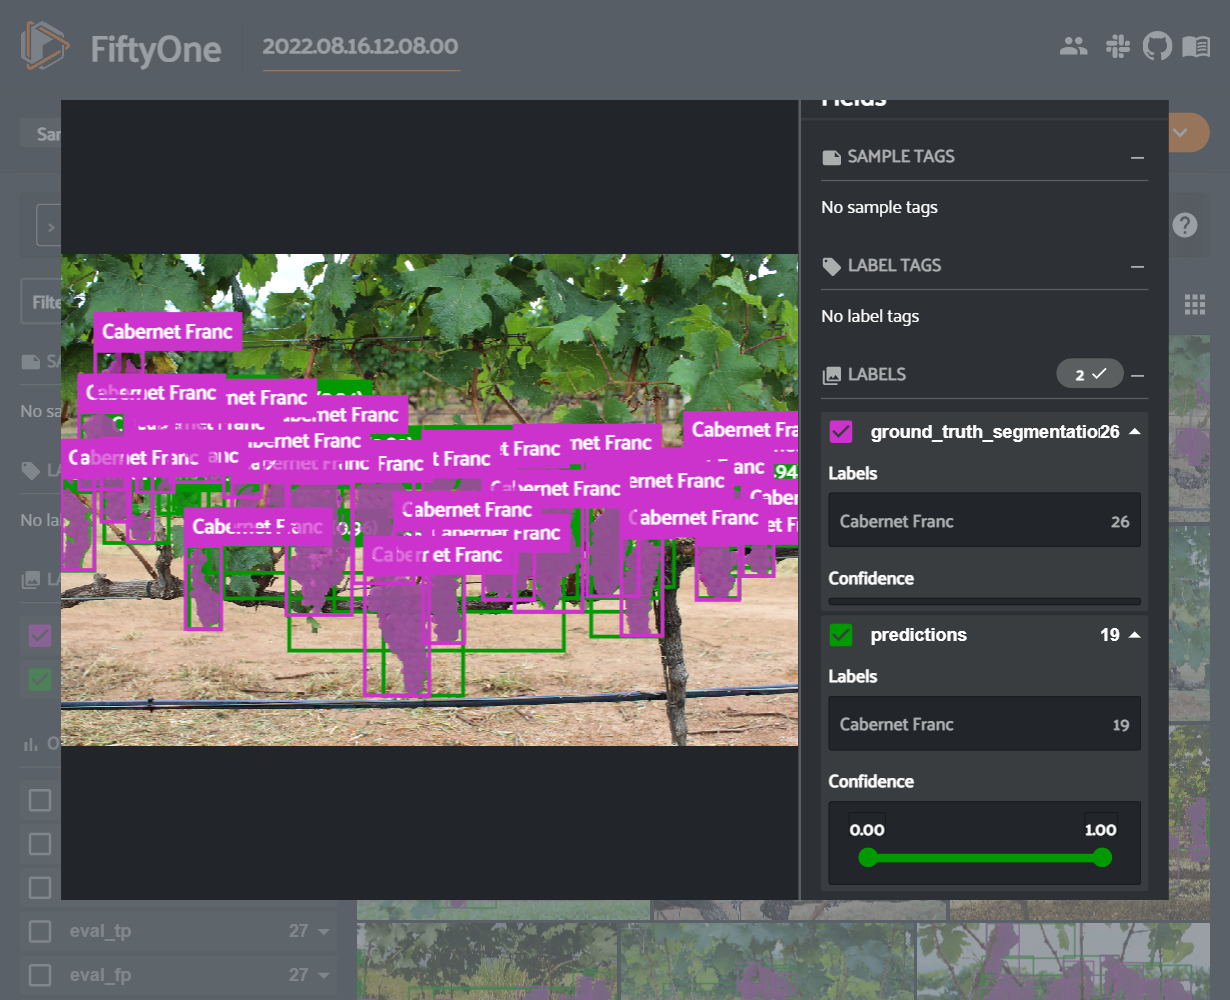

In [89]:
session.view = half_conf_view.sort_by("eval_fp", reverse=True)

Object view

In [90]:
session = fo.launch_app(dataset.to_evaluation_patches('eval'))

## Confusion matrix

In [102]:
import pandas as pd

In [103]:
ddf = pd.DataFrame({'a': [1, 2, 3.5], 'b': ['a', 'a', 'c']})

In [104]:
ddf['b'].to_list()

['a', 'a', 'c']

In [91]:
plot = results.plot_confusion_matrix()
plot.show()

# Connect to session
session.plots.attach(plot)

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',…

In [92]:
from sklearn.metrics import ConfusionMatrixDisplay

In [93]:
confusion_matrix, labels, ids = results._confusion_matrix()

In [94]:
normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

C:\Users\M\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [95]:
disp = ConfusionMatrixDisplay(confusion_matrix=normalized_confusion_matrix,
                             display_labels=labels)

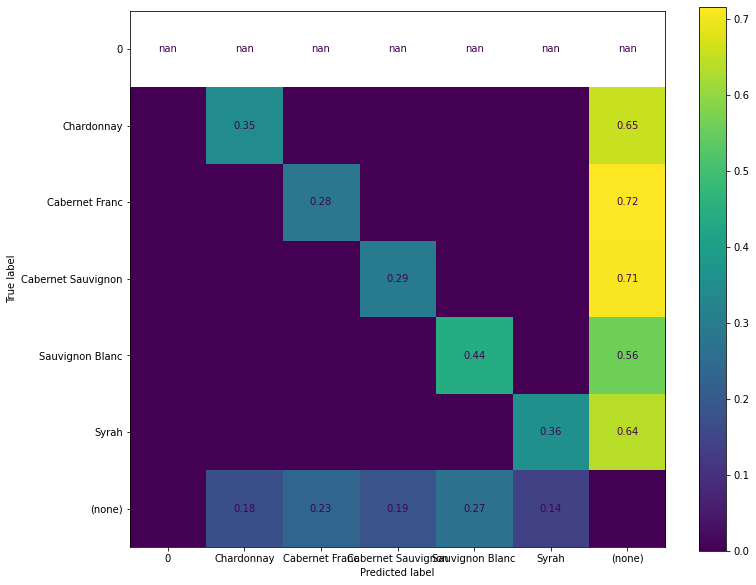

In [96]:
fig, ax = plt.subplots(figsize=(12,10))
disp.plot(ax=ax)

## precision-recall

In [99]:
results_all = dataset.evaluate_detections( #dataset.evaluate_detections
    "predictions",
    gt_field="ground_truth_segmentations",
    eval_key="eval",
    compute_mAP=True,
)

print("\nmAP: %.4f" % results.mAP())

Evaluating detections...
 100% |███████████████████| 27/27 [2.8s elapsed, 0s remaining, 9.1 samples/s]       
Performing IoU sweep...
 100% |███████████████████| 27/27 [1.3s elapsed, 0s remaining, 20.5 samples/s]         

mAP: 0.1479


In [100]:
plot = results_all.plot_pr_curves() #plot_pr_curves(classes=['UP', 'UPn', 'WKn', 'WSn'])
plot.show()

FigureWidget({
    'data': [{'hovertemplate': '<b>class: %{text}</b><br>recall: %{x}<br>precision: %{y}<extra>…